In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import GradientBoostingRegressor
from tqdm.notebook import tqdm

## Data Preparation

In [2]:
# Load dataframes from pickle file
with open('../data/data_full.pkl', 'rb') as f:
    data, data_norm = pickle.load(f)

In [3]:
def is_outlier(data, rolling_median, thresh):
    if not pd.isna(rolling_median):
        return abs(data - rolling_median) >= thresh

In [4]:
# Remove outliers/point anomalies
data_nrm5 = data_norm.rolling(5, center=True).median()
data_nc = data_norm.copy()
s = data_nc.shape
for j in range(s[1]):
    for i in range(s[0]):
        if is_outlier(data_nc.iloc[i, j], data_nrm5.iloc[i, j], 0.2):
            data_nc.iloc[i, j] = data_nrm5.iloc[i, j]

## Feature Extraction and Regression

In [5]:
def ts_to_features(ts, n_features=61):
    X, y = np.zeros([len(ts) - n_features, n_features]), np.zeros([len(ts) - n_features, 1])
    for i in range(len(ts)-n_features):
        X[i, :] = ts[i:i+n_features]
        y[i] = ts[i+n_features]
    return X, y.flatten()

In [6]:
def ts_predict(X, y):
    lower_alpha = 0.1
    upper_alpha = 0.9
    predictions = np.ones([1, 4])
    for i in tqdm(range(1, X.shape[0])):
        lower_model = GradientBoostingRegressor(loss="quantile",                   
                                        alpha=lower_alpha)
        mid_model = GradientBoostingRegressor(loss="ls")
        upper_model = GradientBoostingRegressor(loss="quantile",
                                                alpha=upper_alpha)
        lower_model.fit(X[:i,:], y[:i])
        mid_model.fit(X[:i,:], y[:i])
        upper_model.fit(X[:i,:], y[:i])
        
        pred = np.hstack([y[i], 
                          lower_model.predict(X[i:i+1, :]),
                          mid_model.predict(X[i:i+1, :]),
                          upper_model.predict(X[i:i+1, :])])
        predictions = np.vstack([predictions, pred])
    return predictions[1:, :]

In [7]:
# Hourly sample the Ozone data, extract features and calculate prediction intervals
h = data_nc.iloc[:, 0].values
h = h[range(0, len(h), 61)]
X, y = ts_to_features(h, 5)
p = ts_predict(X, y)

In [8]:
# Create labels for data points based on in/out of the prediction interval
p = pd.DataFrame(p)
p.columns = ['actual', 'lower', 'mid', 'upper']
p['label'] = np.ones(len(p))
for i in range(len(p)):
    if p['actual'].iloc[i] > p['upper'].iloc[i]:
        p['label'].iloc[i] = 2
    if p['actual'].iloc[i] < p['lower'].iloc[i]:
        p['label'].iloc[i] = 0

## Visualization

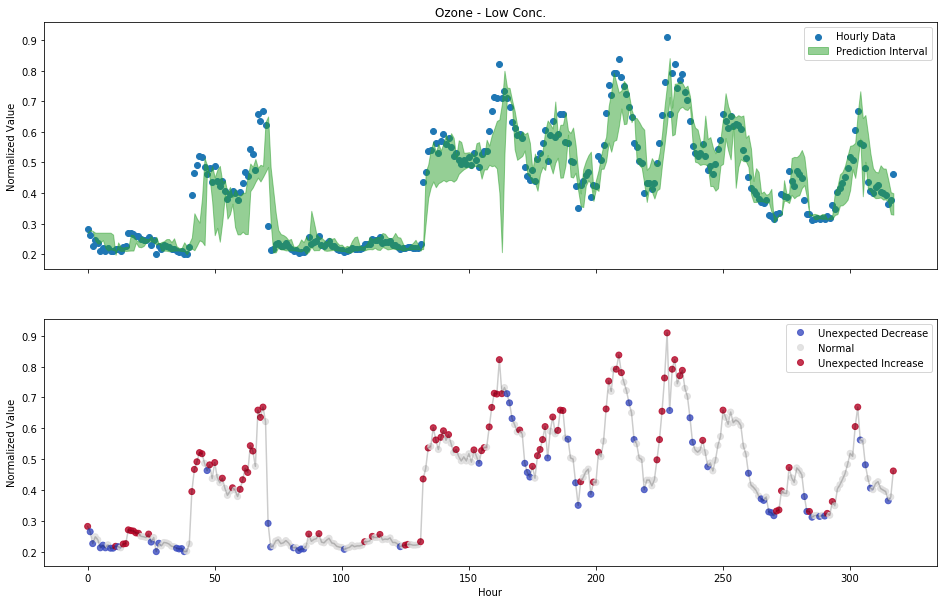

In [9]:
# Plot two scatter plots, showing the prediction interval and labels
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 10))
ax1.scatter(p.index, p['actual'], color='tab:blue', alpha=1, label='Hourly Data')
ax1.fill_between(p.index, p['upper'], p['lower'], color='tab:green', alpha=0.5, label='Prediction Interval')
ax1.set_ylabel('Normalized Value')
ax1.legend()
ax1.set_title('Ozone - Low Conc.')
ax2.plot(p['actual'], color='black', alpha=0.2)
scatter = ax2.scatter(p.index, p['actual'], c=p['label'], cmap=plt.get_cmap('coolwarm'), alpha=0.8)
ax2.set_xlabel('Hour')
ax2.set_ylabel('Normalized Value')
ax2.legend(handles=scatter.legend_elements()[0], labels=['Unexpected Decrease', 'Normal', 'Unexpected Increase'])
plt.show()